In [6]:
import sys
sys.path.append('../')

import numpy as np
import Corrfunc
from os.path import dirname, abspath, join as pjoin
#from Corrfunc.io import read_catalog
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
def rp_pi_counts_to_smu( Ncounts, sbin, mubin ):
    #rp = Ncounts['rpavg']
    rp = (Ncounts['rmax']+Ncounts['rmax'])/2.
    pi = Ncounts['pimax'] - 0.5
    npairs = Ncounts['npairs']# * Ncounts['weightavg']
    s = np.sqrt(rp**2 + pi**2)
    mu = pi/s
   
    new_npairs = np.zeros((sbin.size-1, mubin.size-1))
    wsqr = np.zeros((sbin.size-1, mubin.size-1))
    for i in range(s.size-1):
        ind_s = np.digitize( s[i], sbin )
        ind_mu = np.digitize( mu[i], mubin )
        #print s[i], mu[i], ind_s, ind_mu, npairs[i]
        if ind_s == 0 or ind_s == sbin.size: pass
        elif ind_mu == 0 or ind_mu == mubin.size: pass
        else : new_npairs[ind_s-1, ind_mu-1] += npairs[i]

    return new_npairs

def cf_smu( DD_counts, DR_counts, RR_counts, sbin, mubin, N, Nrand):        

    #fN = np.float(Nrand)/np.float(N)
    DD_counts_smu = rp_pi_counts_to_smu( DD_counts, sbin, mubin )
    DR_counts_smu = rp_pi_counts_to_smu( DR_counts, sbin, mubin )
    RR_counts_smu = rp_pi_counts_to_smu( RR_counts, sbin, mubin )

    #fN = np.sqrt( np.sum(RR_counts_smu)*1./np.sum(DD_counts_smu) )
 
    # total weight
    wd = np.sqrt(np.sum(DD_counts_smu))
    wdr = np.sqrt(np.sum(DR_counts_smu))
    wr = np.sqrt(np.sum(RR_counts_smu))

    # normalization
    norm_DD = DD_counts_smu * 1./wd**2
    norm_DR = DR_counts_smu * 1./wdr**2
    norm_RR = RR_counts_smu * 1./wr**2

    zeromask = (norm_RR == 0.0)
    norm_RR[zeromask] = 0.0  # to avoid zero divide error. will be excluded at the end.

    #xi = (fN**2*norm_DD - 2*fN* norm_DR + norm_RR)/(norm_RR)
    xi = (norm_DD - 2*norm_DR + norm_RR)/(norm_RR)

    xi[zeromask] = 0.0
    
    return xi

In [2]:
import numpy as np
import Corrfunc
from os.path import dirname, abspath, join as pjoin
from Corrfunc.io import read_catalog
import esutil

cmass_south = esutil.io.read('/n/des/lee.5922/data/cmass_cat/galaxy_DR12v5_CMASS_South_DC.fits.gz'
                                  , ensure_native =True)
#cmass_north = esutil.io.read('/n/des/lee.5922/data/cmass_cat/galaxy_DR12v5_CMASS_North_DC.fits.gz'
#                                  , ensure_native =True)

randoms_south = esutil.io.read('/n/des/lee.5922/data/cmass_cat/random0_DR12v5_CMASS_South_DC.fits.gz'
                                    , columns=['RA', 'DEC', 'Z', 'DC','WEIGHT_FKP'], ensure_native =True)
#randoms_north = esutil.io.read('/n/des/lee.5922/data/cmass_cat/random0_DR12v5_CMASS_North_DC.fits.gz'
#                                    , columns=['RA', 'DEC', 'Z', 'DC', 'WEIGHT_FKP'], ensure_native =True)

In [4]:
indrand = np.random.choice(randoms_south.size, size = randoms_south.size/10)

In [5]:
randoms_south = randoms_south[indrand]

In [25]:
RA, DEC, CZ = cmass_south['RA'], cmass_south['DEC'], cmass_south['DC']
WEIGHT = np.float64(cmass_south['WEIGHT_FKP']*cmass_south['WEIGHT_SYSTOT']*(cmass_south['WEIGHT_NOZ']+cmass_south['WEIGHT_CP']-1)) 
N = RA.size
RAND_RA, RAND_DEC, RAND_CZ = randoms_south['RA'], randoms_south['DEC'], randoms_south['DC'] 
RAND_WEIGHT = np.float64(randoms_south['WEIGHT_FKP'])
rand_N = RAND_RA.size

In [ ]:
from Corrfunc.mocks.DDrppi_mocks import DDrppi_mocks
results_DDrppi_mocks = DDrppi_mocks(1, 2, 20, pimax, rbins, RA, DEC, CZ, is_comoving_dist=comoving)
results_DRrppi_mocks = DDrppi_mocks(0, 2, 20, pimax, rbins, RA, DEC, CZ, RA2=RAND_RA, DEC2=RAND_DEC, CZ2=RAND_CZ, is_comoving_dist=comoving)
results_RRrppi_mocks = DDrppi_mocks(1, 2, 20, pimax, rbins, RAND_RA, RAND_DEC, RAND_CZ, is_comoving_dist=comoving)    

In [44]:
from Corrfunc.utils import convert_rp_pi_counts_to_wp
wp = convert_rp_pi_counts_to_wp(N, N, rand_N, rand_N,
                                 results_DDrppi_mocks, results_DRrppi_mocks,
                                 results_DRrppi_mocks, results_RRrppi_mocks, nbins, pimax)

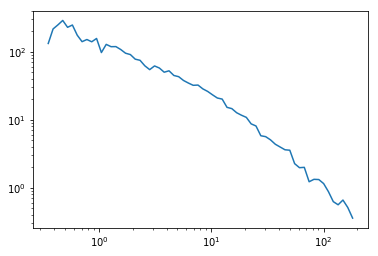

In [45]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.loglog(rbins[:-1], wp )

In [46]:
sbin = np.linspace(40, 200, 20)

In [47]:
results_DDrppi_mocks['npairs']

array([     54,       0,       0, ..., 1665024, 1660216, 1657178],
      dtype=uint64)

In [48]:
DD_counts_smu = rp_pi_counts_to_smu( results_DDrppi_mocks, sbin, mubins )
DR_counts_smu = rp_pi_counts_to_smu( results_DRrppi_mocks, sbin, mubins )
RR_counts_smu = rp_pi_counts_to_smu( results_RRrppi_mocks, sbin, mubins )

In [10]:
WEIGHT

array([0.78129071, 0.26221457, 0.3515543 , ..., 0.70903438, 0.33493173,
       0.21407673])

In [ ]:
from Corrfunc.mocks.DDsmu_mocks import DDsmu_mocks

mumax = 1
nmubins = 100
mubins, mus = np.linspace(0, mumax, nmubins, retstep=True)
sbins = np.linspace(0.1, 200, 40)
comoving = False
nthreads = 30 

comoving = True
DD_counts_smu = DDsmu_mocks(1, 2, nthreads, mumax, nmubins, sbins, RA, DEC, CZ, weights1 = WEIGHT, 
                            verbose = True, is_comoving_dist=comoving, weight_type="pair_product" )

DR_counts_smu = DDsmu_mocks(0, 2, nthreads, mumax, nmubins, sbins, RA, DEC, CZ, RA2=RAND_RA, DEC2=RAND_DEC, CZ2=RAND_CZ, 
                            weights1 = WEIGHT, weights2 = RAND_WEIGHT, verbose = True, is_comoving_dist=comoving,\
                            weight_type="pair_product")
RR_counts_smu = DDsmu_mocks(1, 2, nthreads, mumax, nmubins, sbins, RAND_RA, RAND_DEC, RAND_CZ, \
                            weights1 = RAND_WEIGHT, verbose = True, is_comoving_dist=comoving,\
                            weight_type="pair_product")


In gridlink_mocks_index_particles_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 22,29,8.  Time taken =   0.036 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  2.020 secs
In gridlink_mocks_index_particles_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,32,9.  Time taken =   0.035 sec
In gridlink_mocks_index_particles_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,32,9.  Time taken =   2.437 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%......100% done. Time taken =     3 mins   27 secs
In gridlink_mocks_index_particles_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,32,9.  Time taken =   2.450 sec
countpairs_mocks_s_mu_double> gridlink seems inefficient. nmesh = (25, 32, 9); avg_np = 1.62e+03. Boosting bin refine factor - should lead to better performance
In gridlink_mocks_index_particles_double> Running with [nmesh_x, nmesh_y, n

In [11]:
DD_counts_smu['weightavg']

array([0.08247452, 0.08217628, 0.08176756, ..., 0.09647779, 0.09676369,
       0.098195  ])

In [12]:
DD_counts_smu['npairs']

array([ 41718,  42212,  41420, ..., 531316, 532036, 541322], dtype=uint64)

In [13]:
DD_counts_smu['npairs']

array([ 41718,  42212,  41420, ..., 531316, 532036, 541322], dtype=uint64)

In [17]:
WEIGHT

array([0.78129071, 0.26221457, 0.3515543 , ..., 0.70903438, 0.33493173,
       0.21407673])

In [21]:
N = RA.size
rand_N = RAND_RA.size

weightedN = np.sum(WEIGHT)
weighted_rand_N = np.sum(RAND_WEIGHT)

from Corrfunc.utils import convert_3d_counts_to_cf
from systematics_module.corr import convert_3d_counts_to_cf_weight
result_cf_weight = convert_3d_counts_to_cf_weight(weightedN, weightedN, weighted_rand_N, weighted_rand_N,
                              DD_counts_smu, DR_counts_smu,
                              DR_counts_smu, RR_counts_smu)

result_cf = convert_3d_counts_to_cf(N, N, rand_N,rand_N,
                              DD_counts_smu, DR_counts_smu,
                              DR_counts_smu, RR_counts_smu)

result_cf_weight_reshape = result_cf_weight.reshape(sbins.size-1,nmubins)
result_cf_reshape = result_cf.reshape(sbins.size-1,nmubins)
#result_cf = cf_smu( results_DDrppi_mocks, results_DRrppi_mocks, results_RRrppi_mocks, sbin, mubins, N, rand_N)

In [13]:
import scipy
from scipy.special import eval_legendre

#mubins, mus = np.linspace(0, mumax, nmubins, retstep=True)
#mucenter = mubins[:-1]+mus/2.
legendre0 = np.array([scipy.special.eval_legendre(0,m) for m in mubins]).ravel() 
legendre2 = np.array([scipy.special.eval_legendre(2,m) for m in mubins]).ravel() 

xi_monopole_weight = np.sum(result_cf_weight_reshape * legendre0.T, axis = 1)/mubins.size
xi_monopole = np.sum(result_cf_reshape * legendre0.T, axis = 1)/mubins.size

NameError: name 'result_cf_reshape' is not defined

In [ ]:
import pickle
DD_counts_smu = pickle.load(open('../data_txt/full_cmass_single//dd_jk0.pkl'))
DR_counts_smu = pickle.load(open('../data_txt/full_cmass_single//dr_jk0.pkl'))
RR_counts_smu = pickle.load(open('../data_txt/full_cmass_single//rr_jk0.pkl'))

from systematics_module.corr import convert_3d_counts_to_cf_weight
result_cf_weight = convert_3d_counts_to_cf_weight(291199.06, 291199.06, 14029838.044708865, 14029838.044708865,
                              DD_counts_smu, DR_counts_smu,
                              DR_counts_smu, RR_counts_smu)
result_cf_weight_reshape = result_cf_weight.reshape(39, 100) 

import scipy
from scipy.special import eval_legendre

mubins, mus = np.linspace(0, 1, 100, retstep=True)
sbins, ss = np.linspace(0.1, 200, 40, retstep=True)
#mucenter = mubins[:-1]+mus/2.
legendre0 = np.array([scipy.special.eval_legendre(0,m) for m in mubins]).ravel() 
legendre2 = np.array([scipy.special.eval_legendre(2,m) for m in mubins]).ravel() 

xi_monopole_weight = np.sum(result_cf_weight_reshape * legendre0.T, axis = 1)/mubins.size

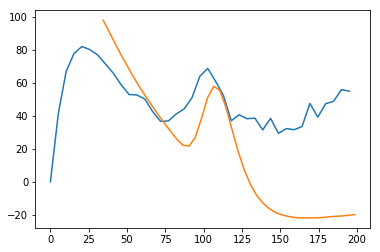

In [16]:
import matplotlib.pyplot as plt

theory_corr = np.genfromtxt('../../../bandpower/SNR/data_txt/datav/mcmc_Ashley_xionly_b_p0.datavector')[1500:1500+42]
theory_rr = np.linspace(32, 200, 43)[:-1] + 2.5

fig, ax = plt.subplots()
#ax.plot(sbins[:-1], sbins[:-1]**2*xi_monopole)
ax.plot(sbins[:-1], sbins[:-1]**2*xi_monopole_weight)
ax.plot(theory_rr[::-1], theory_rr[::-1]**2*theory_corr)


In [ ]:
from scipy.special import eval_legendre

mubins, mus = np.linspace(0, mumax, nmubins, retstep=True)
mucenter = mubins[:-1]+mus/2.
legendre0 = np.array([scipy.special.eval_legendre(0,m) for m in mucenter]).ravel() 
legendre2 = np.array([scipy.special.eval_legendre(2,m) for m in mucenter]).ravel() 

xi_monopole = np.sum(cf_smu * legendre0.T, axis = 1)/mucenter.size

In [49]:
result_cf = cf_smu( results_DDrppi_mocks, results_DRrppi_mocks, results_RRrppi_mocks, sbin, mubins, N, rand_N)

import scipy
from scipy.special import eval_legendre
mucenter = mubins[:-1]+mus/2.
legendre0 = np.array([scipy.special.eval_legendre(0,m) for m in mucenter]).ravel() 
legendre2 = np.array([scipy.special.eval_legendre(2,m) for m in mucenter]).ravel() 

xi_monopole = np.sum(result_cf * legendre0.T, axis = 1)/mucenter.size

/n/home00/lee.5922/.local/lib/python2.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in divide


In [50]:
xi_monopole

array([ 3.15925342e-02,  1.73104734e-02,  1.35098092e-02,  4.77164001e-03,
        2.58067434e-03,  1.69429455e-03,  1.18947895e-03,  9.50473030e-04,
        8.91128899e-04, -1.52493701e-03, -9.45978990e-04, -8.21672909e-04,
       -1.06488504e-03, -1.10317768e-03, -8.78181773e-04, -9.02514799e-04,
       -1.20183726e-03, -8.14461088e-04, -8.62417410e-05])

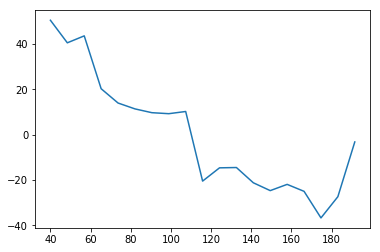

In [51]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(sbin[:-1], sbin[:-1]**2*xi_monopole)